canvas_size:  [2368, 5032]
canvas_size:  [2468, 5532]


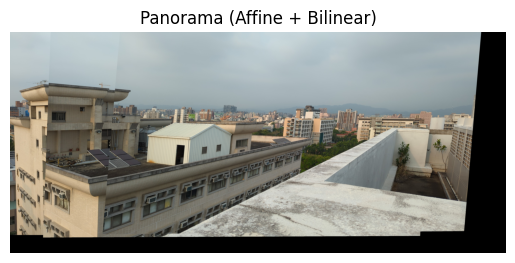

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def bilinear_interpolate(img, x, y):
    h, w = img.shape[:2]
    if x < 0 or x >= w - 1 or y < 0 or y >= h - 1:
        return np.zeros(3, dtype=np.uint8)

    x0, y0 = int(x), int(y)
    x1, y1 = x0 + 1, y0 + 1
    dx, dy = x - x0, y - y0

    top_left = img[y0, x0]
    top_right = img[y0, x1]
    bottom_left = img[y1, x0]
    bottom_right = img[y1, x1]

    top = (1 - dx) * top_left + dx * top_right
    bottom = (1 - dx) * bottom_left + dx * bottom_right
    interpolated = (1 - dy) * top + dy * bottom
    return interpolated.astype(np.uint8)

def warp_affine_manual(src, M, out_size):
    h, w = out_size
    warped = np.zeros((h, w, 3), dtype=np.uint8)
    for y in range(h):
        for x in range(w):
            src_pt = np.linalg.inv(M) @ np.array([x, y, 1])
            px, py = src_pt[0], src_pt[1]
            warped[y, x] = bilinear_interpolate(src, px, py)
    return warped

def find_affine_matrix(src_pts, dst_pts):
    assert src_pts.shape == (3, 2) and dst_pts.shape == (3, 2), "Need 3 points for affine transform"
    A = []
    b = []
    for i in range(3):
        x, y = src_pts[i]
        u, v = dst_pts[i]
        A.append([x, y, 1, 0, 0, 0])
        A.append([0, 0, 0, x, y, 1])
        b.append(u)
        b.append(v)
    A = np.array(A)
    b = np.array(b)
    M = np.linalg.solve(A, b).reshape(2, 3)
    M_affine = np.vstack([M, [0, 0, 1]])  # Convert to 3x3
    return M_affine

def stitch_images_automated(base_img, img_to_warp, src_pts, dst_pts, out_size):
    M = find_affine_matrix(src_pts, dst_pts)
    warped = warp_affine_manual(img_to_warp, M, out_size)
    base_copy = np.zeros_like(warped)
    bh, bw = base_img.shape[:2]
    base_copy[:bh, :bw] = base_img

    mask = np.any(warped > 0, axis=2)
    base_copy[mask] = warped[mask]
    return base_copy

# main program
img1 = cv2.imread("IMG_20250430_171640.jpg")
img2 = cv2.imread("IMG_20250430_171705.jpg")
img3 = cv2.imread("IMG_20250430_171725.jpg")

# 第一階段：將img2對齊img1
canvas_size = [img1.shape[0] + 100, img1.shape[1] + 1000]
print("canvas_size: ", canvas_size)
dst_pts = np.array([[2601, 1647], [2009, 930], [3176, 972]])    # 第一張
src_pts = np.array([[2117, 1641], [1524, 936], [2644, 982]])    # 第二張
stitched_12 = stitch_images_automated(img1, img2, src_pts, dst_pts, canvas_size)

# 第二階段：將img3對齊stitched_12
canvas_size = [stitched_12.shape[0] + 100, stitched_12.shape[1] + 500]
print("canvas_size: ", canvas_size)
dst_pts = np.array([[2601, 1647], [2009, 930], [3176, 972]])    # 1+2 (用第一張的點即可)
src_pts = np.array([[1517, 1669], [863, 947], [2034, 999]])    # 第三張
final_panorama = stitch_images_automated(stitched_12, img3, src_pts, dst_pts, canvas_size)

# 顯示結果
plt.imshow(cv2.cvtColor(final_panorama, cv2.COLOR_BGR2RGB))
plt.title("Panorama (Affine + Bilinear)")
plt.axis('off')
plt.show()